# 你的第一个GAN

### 目标
在这个笔记本中，你将为本课程创建你的第一个生成对抗网络（GAN）！具体来说，你将构建和训练一个可以生成手写数字（0-9）图像的GAN。在这个专项课程中，你将使用PyTorch，因此如果你对这个框架不熟悉，可以参考[PyTorch文档](https://pytorch.org/docs/stable/index.html)。提示通常也会包含相关文档的链接。

### 学习目标
1. 从头构建GAN的生成器和判别器组件。
2. 创建生成器和判别器的损失函数。
3. 训练你的GAN并可视化生成的图像。

## 开始
您将首先导入一些有用的包和您将用于构建和训练 GAN 的数据集。您还提供了一个可视化函数，以帮助您检查您的 GAN 将创建的图像。

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### MNIST 数据集
您的判别器将使用一个名为 [MNIST](http://yann.lecun.com/exdb/mnist/) 的数据集中的训练图像。它包含 60,000 张手写数字的图像，从 0 到 9，如下所示：

![MNIST 数字](MnistExamples.png)

您可能会注意到这些图像有些像素化——这是因为它们的大小仅为 28 x 28！图像的小尺寸使得 MNIST 非常适合简单的训练。此外，这些图像也是黑白的，因此只需要一个维度，或称“颜色通道”，来表示它们（关于这一点在课程中后面会详细讲解）。

#### 张量
您将使用 [张量](https://pytorch.org/docs/stable/tensors.html) 来表示数据。张量是矩阵的推广：例如，一个包含红色、绿色和蓝色在 64 x 64 像素图像中不同位置的三维矩阵堆叠就是一个形状为 3 x 64 x 64 的张量。

张量易于操作，并受到您将使用的机器学习库 [PyTorch](https://pytorch.org/) 的支持。您可以自由探索它们，但可以将其想象为多维矩阵或向量！

#### 批次
虽然您可以在生成一幅图像后训练您的模型，但这非常低效，并导致训练不稳定。在 GAN 和机器学习中，您将在每个训练步骤中处理多幅图像。这些被称为批次。

这意味着您的生成器将生成整批图像，并在更新模型之前收到判别器对每个图像的反馈。判别器也是如此，它将计算整批生成图像以及真实图像的损失，然后再更新模型。

## 生成器
第一步是构建生成器组件。

你将通过创建一个函数来制作生成器神经网络的单个层/块。每个块应该包括一个 [线性变换](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) 以映射到另一种形状，一个 [批量归一化](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) 以实现稳定，最后是一个非线性激活函数（你在这里使用 [ReLU](https://pytorch.org/docs/master/generated/torch.nn.ReLU.html)），以便输出可以以复杂的方式进行转换。你将在课程稍后部分了解更多有关激活和批量归一化的内容。

In [2]:
# UNQ_C1 (唯一单元标识符，禁止编辑)  
# 评分函数: get_generator_block  
def get_generator_block(input_dim, output_dim):  
    '''  
    返回生成器神经网络的一块，根据输入和输出维度。  
    参数:  
        input_dim: 输入向量的维度，标量  
        output_dim: 输出向量的维度，标量  
    返回:  
        一个生成器神经网络层，包含线性变换，  
          随后是批量归一化，然后是 ReLU 激活函数  
    '''  
    return nn.Sequential(  
        # 提示: 用适当的维度替换所有的 "None"。  
        # 如果你不太熟悉 PyTorch，文档可能会很有用：  
        # https://pytorch.org/docs/stable/nn.html。  
        #### 在这里开始编码 ####  
        nn.Linear(input_dim, output_dim),  
        nn.BatchNorm1d(output_dim, eps=1e-5), 
        #### 在这里结束编码 ####  
        nn.ReLU(inplace=True)  
    )

In [3]:
# Verify the generator block function
def test_gen_block(in_features, out_features, num_test=1000):
    block = get_generator_block(in_features, out_features)

    # Check the three parts
    assert len(block) == 3
    assert type(block[0]) == nn.Linear
    assert type(block[1]) == nn.BatchNorm1d
    assert type(block[2]) == nn.ReLU
    
    # Check the output shape
    test_input = torch.randn(num_test, in_features)
    test_output = block(test_input)
    assert tuple(test_output.shape) == (num_test, out_features)
    assert test_output.std() > 0.55
    assert test_output.std() < 0.65

test_gen_block(25, 12)
test_gen_block(15, 28)
print("Success!")

Success!


现在你可以构建生成器类。它将接受三个值：

* 噪声向量维度
* 图像维度
* 初始隐藏维度

使用这些值，生成器将构建一个包含5层/块的神经网络。从噪声向量开始，生成器将通过块函数应用非线性变换，直到张量被映射到要输出的图像的大小（与MNIST中的真实图像大小相同）。你需要填补最终层的代码，因为它与其他层不同。最终层不需要归一化或激活函数，但需要使用[ sigmoid函数](https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html)进行缩放。

最后，给定一个前向传播函数，该函数接受一个噪声向量并使用你的神经网络生成输出维度的图像。

<details>

<summary>
<font size="3" color="green">
<b>针对<code><font size="4">生成器</font></code>的可选提示</b>
</font>
</summary>

1. 最后线性变换的输出大小应为im_dim，但请记住，你需要使用sigmoid函数将输出缩放到0和1之间。
2. [nn.Linear](https://pytorch.org/docs/master/generated/torch.nn.Linear.html)和[nn.Sigmoid](https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html)在这里将非常有用。
</details>

In [4]:
# UNQ_C2 (唯一单元标识符，切勿编辑)  
# GRADED FUNCTION: 生成器  
class Generator(nn.Module):  
    '''  
    生成器类  
    属性：  
        z_dim: 噪音向量的维度，一个标量  
        im_dim: 图像的维度，适合所使用的数据集，一个标量  
          （MNIST图像是28 x 28 = 784 所以这就是默认值）  
        hidden_dim: 内部维度，一个标量  
    '''  
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):  
        super(Generator, self).__init__()  
        # 构建神经网络  
        self.gen = nn.Sequential(  
            get_generator_block(z_dim, hidden_dim),  
            get_generator_block(hidden_dim, hidden_dim * 2),  
            get_generator_block(hidden_dim * 2, hidden_dim * 4),  
            get_generator_block(hidden_dim * 4, hidden_dim * 8),  
            # 如果需要提示，有下拉框可供选择！  
            #### 在此处开始编码 ####  
            nn.Linear(hidden_dim * 8, im_dim),  
            nn.Sigmoid()  
            #### 在此处结束编码 ####  
        )  
    def forward(self, noise):  
        '''  
        完成生成器的正向传播函数：给定一个噪音张量，   
        返回生成的图像。  
        参数：  
            noise: 具有维度(n_samples, z_dim)的噪音张量  
        '''  
        return self.gen(noise)  
    
    # 评分所需  
    def get_gen(self):  
        '''  
        返回：  
            顺序模型  
        '''  
        return self.gen

In [5]:
# Verify the generator class
def test_generator(z_dim, im_dim, hidden_dim, num_test=10000):
    gen = Generator(z_dim, im_dim, hidden_dim).get_gen()
    
    # Check there are six modules in the sequential part
    assert len(gen) == 6
    test_input = torch.randn(num_test, z_dim)
    test_output = gen(test_input)

    # Check that the output shape is correct
    assert tuple(test_output.shape) == (num_test, im_dim)
    assert test_output.max() < 1, "Make sure to use a sigmoid"
    assert test_output.min() > 0, "Make sure to use a sigmoid"
    assert test_output.min() < 0.5, "Don't use a block in your solution"
    assert test_output.std() > 0.05, "Don't use batchnorm here"
    assert test_output.std() < 0.15, "Don't use batchnorm here"

test_generator(5, 10, 20)
test_generator(20, 8, 24)
print("Success!")

Success!


## 噪声
要能够使用您的生成器，您需要能够创建噪声向量。噪声向量 z 在确保来自同一类别的生成图像不会完全相同方面发挥着重要作用——可以把它看作是一个随机种子。您将通过从正态分布中采样随机数，使用 PyTorch 随机生成它。由于每次传递将处理多个图像，您将一次性生成所有噪声向量。

请注意，每当您使用 torch.ones、torch.zeros 或 torch.randn 创建新的张量时，您需要在目标设备上创建它，例如 `torch.ones(3, 3, device=device)`，或者使用 `torch.ones(3, 3).to(device)` 将其移动到目标设备。如果您通过操作另一个张量或使用默认设备为输入的变体（例如 `torch.ones_like`）来创建张量，则无需执行此操作。通常情况下，尽可能使用 `torch.ones_like` 和 `torch.zeros_like` 替代 `torch.ones` 或 `torch.zeros`。

<details/>

<summary>
<font size="3" color="green">
<b>可选提示 <code><font size="4">get_noise</font></code></b>
</font>
</summary>

1. 
您可能会发现 [torch.randn](https://pytorch.org/docs/master/generated/torch.randn.html) 在这里非常有用。
</details>

In [6]:
# UNQ_C3 (唯一单元标识符，勿编辑)  
# GRADED FUNCTION: get_noise  
def get_noise(n_samples, z_dim, device='cpu'):  
    '''  
    创建噪声向量的函数：给定维度 (n_samples, z_dim)，  
    创建一个该形状的张量，填充来自正态分布的随机数。  
    参数：  
        n_samples: 要生成的样本数量，一个标量  
        z_dim: 噪声向量的维度，一个标量  
        device: 设备类型  
    '''  
    # 注意：要在GPU上使用 device='cuda'，请确保将设备  
    # 参数传递给生成噪声的函数。  
    #### 在此处开始代码 ####  
    return torch.randn(n_samples, z_dim, device=device)  
    #### 代码结束 ####"""

In [7]:
# Verify the noise vector function
def test_get_noise(n_samples, z_dim, device='cpu'):
    noise = get_noise(n_samples, z_dim, device)
    
    # Make sure a normal distribution was used
    assert tuple(noise.shape) == (n_samples, z_dim)
    assert torch.abs(noise.std() - torch.tensor(1.0)) < 0.01
    assert str(noise.device).startswith(device)

test_get_noise(1000, 100, 'cpu')
if torch.cuda.is_available():
    test_get_noise(1000, 32, 'cuda')
print("Success!")

Success!


## 判别器
您需要构建的第二个组件是判别器。与生成器组件一样，您将首先创建一个函数来构建判别器的神经网络块。

*注意：您使用泄漏ReLU以防止“死亡ReLU”问题，这指的是参数因持续传递给ReLU的负值而停止变化，导致零梯度的现象。您将在接下来的讲座中了解更多关于这一点的内容！*

修正线性单元（ReLU） | 泄漏ReLU
:-------------------------:|:-------------------------:
![](./relu-graph.png)  |  ![](./lrelu-graph.png)

In [8]:
# UNQ_C4 (唯一单元标识符，请勿编辑)  
# GRADED FUNCTION: get_discriminator_block  
def get_discriminator_block(input_dim, output_dim):  
    '''  
    判别器块  
    返回给定输入和输出维度的判别器神经网络的函数。  
    参数：  
        input_dim: 输入向量的维度，标量  
        output_dim: 输出向量的维度，标量  
    返回：  
        一个判别器神经网络层，包含一个线性变换   
          后跟一个负斜率为0.2的nn.LeakyReLU激活函数   
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)  
    '''  
    return nn.Sequential(  
        #### 在这里开始代码 ####  
        nn.Linear(input_dim, output_dim),  
        nn.LeakyReLU(0.2)  
        #### 在这里结束代码 ####  
    )

In [9]:
# Verify the discriminator block function
def test_disc_block(in_features, out_features, num_test=10000):
    block = get_discriminator_block(in_features, out_features)

    # Check there are two parts
    assert len(block) == 2
    test_input = torch.randn(num_test, in_features)
    test_output = block(test_input)

    # Check that the shape is right
    assert tuple(test_output.shape) == (num_test, out_features)
    
    # Check that the LeakyReLU slope is about 0.2
    assert -test_output.min() / test_output.max() > 0.1
    assert -test_output.min() / test_output.max() < 0.3
    assert test_output.std() > 0.3
    assert test_output.std() < 0.5

test_disc_block(25, 12)
test_disc_block(15, 28)
print("Success!")

Success!


现在你可以使用这些模块来制作一个判别器！判别器类包含两个值：

*   图像维度
*   隐藏维度

判别器将构建一个包含四层的神经网络。它将从图像张量开始并进行转换，直到返回一个单一的数字（1维张量）输出。该输出用于分类一幅图像是真还是假。请注意，你不需要在输出层之后使用sigmoid，因为它已包含在损失函数中。最后，使用判别器的神经网络，你可以使用一个前向传播函数，该函数接受一个要分类的图像张量。

In [10]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Discriminator
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            # Hint: You want to transform the final output into a single value,
            #       so add one more linear map.
            #### START CODE HERE ####
            nn.Linear(hidden_dim, 1)
            #### END CODE HERE ####
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

In [11]:
# Verify the discriminator class
def test_discriminator(z_dim, hidden_dim, num_test=100):
    
    disc = Discriminator(z_dim, hidden_dim).get_disc()

    # Check there are three parts
    assert len(disc) == 4

    # Check the linear layer is correct
    test_input = torch.randn(num_test, z_dim)
    test_output = disc(test_input)
    assert tuple(test_output.shape) == (num_test, 1)
    
    # Don't use a block
    assert not isinstance(disc[-1], nn.Sequential)

test_discriminator(5, 10)
test_discriminator(20, 8)
print("Success!")

Success!


## 训练
现在你可以将所有内容结合在一起了！
首先，你将设置你的参数：
  *   criterion: 损失函数
  *   n_epochs: 训练时遍历整个数据集的次数
  *   z_dim: 噪声向量的维度
  *   display_step: 显示/可视化图像的频率
  *   batch_size: 每次前向/后向传播的图像数量
  *   lr: 学习率
  *   device: 设备类型，这里使用 GPU（运行 CUDA），而不是 CPU

接下来，你将使用数据加载器将 MNIST 数据集加载为张量。

In [14]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=False, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

### DO NOT EDIT ###
device = 'cuda' if torch.cuda.is_available() else 'cpu'

现在，您可以初始化生成器、鉴别器和优化器。请注意，每个优化器仅使用一个特定模型的参数，因为我们希望每个优化器只优化其中一个模型。

In [15]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Before you train your GAN, you will need to create functions to calculate the discriminator's loss and the generator's loss. This is how the discriminator and generator will know how they are doing and improve themselves. Since the generator is needed when calculating the discriminator's loss, you will need to call .detach() on the generator result to ensure that only the discriminator is updated!

Remember that you have already defined a loss function earlier (`criterion`) and you are encouraged to use `torch.ones_like` and `torch.zeros_like` instead of `torch.ones` or `torch.zeros`. If you use `torch.ones` or `torch.zeros`, you'll need to pass `device=device` to them.

In [16]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_disc_loss
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    返回给定输入的鉴别器损失。
    参数：
        gen: 生成器模型，给定z维噪声返回一张图像
        disc: 鉴别器模型，返回一个一维的真实/虚假预测值
        criterion: 损失函数，用于将鉴别器的预测与图像的真实情况进行比较 
                   （例如，虚假 = 0，真实 = 1）
        real: 一批真实图像
        num_images: 生成器应该生成的图像数量，
                    这也是真实图像的长度
        z_dim: 噪声向量的维度，一个标量
        device: 设备类型
    返回：
        disc_loss: 当前批次的torch标量损失值
    '''
    #     你需要完成的步骤：
    #       1) 创建噪声向量并生成一批（num_images）虚假图像。 
    #            确保将设备参数传递给噪声。
    #       2) 获取鉴别器对虚假图像的预测 
    #            并计算损失。不要忘记分离生成器！
    #            （记住你之前设置的损失函数 -- criterion。你需要一个 
    #            '真实值'张量来计算损失。 
    #            例如，虚假图像的真实值张量全为零。）
    #       3) 获取鉴别器对真实图像的预测并计算损失。
    #       4) 通过对真实和虚假损失取平均来计算鉴别器的损失
    #            并将其设置为disc_loss。
    #     *重要*: 你不应该在这里编写自己的损失函数 - 使用criterion(pred, true)!
    #### START CODE HERE ####
    inputs = torch.randn(num_images, z_dim).to(device)
    images = gen(inputs)
    y_disc_false = disc(images.detach())
    disc_loss_false = criterion(y_disc_false, torch.zeros_like(y_disc_false))
    y_disc_true = disc(real.detach())
    disc_loss_true = criterion(y_disc_true, torch.ones_like(y_disc_true))
    disc_loss = (disc_loss_false.mean() + disc_loss_true.mean()) / 2
    #### END CODE HERE ####
    return disc_loss

In [17]:
def test_disc_reasonable(num_images=10):
    # Don't use explicit casts to cuda - use the device argument
    import inspect, re
    lines = inspect.getsource(get_disc_loss)
    assert (re.search(r"to\(.cuda.\)", lines)) is None
    assert (re.search(r"\.cuda\(\)", lines)) is None
    
    z_dim = 64
    gen = torch.zeros_like
    disc = lambda x: x.mean(1)[:, None]
    criterion = torch.mul # Multiply
    real = torch.ones(num_images, z_dim)
    disc_loss = get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(disc_loss.mean() - 0.5) < 1e-5)
    
    gen = torch.ones_like
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, z_dim)
    assert torch.all(torch.abs(get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu')) < 1e-5)
    
    gen = lambda x: torch.ones(num_images, 10)
    disc = lambda x: x.mean(1)[:, None] + 10
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, 10)
    assert torch.all(torch.abs(get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu').mean() - 5) < 1e-5)

    gen = torch.ones_like
    disc = nn.Linear(64, 1, bias=False)
    real = torch.ones(num_images, 64) * 0.5
    disc.weight.data = torch.ones_like(disc.weight.data) * 0.5
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    criterion = lambda x, y: torch.sum(x) + torch.sum(y)
    disc_loss = get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu').mean()
    disc_loss.backward()
    assert torch.isclose(torch.abs(disc.weight.grad.mean() - 11.25), torch.tensor(3.75))
    
def test_disc_loss(max_tests = 10):
    z_dim = 64
    gen = Generator(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator().to(device) 
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    num_steps = 0
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradient before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        assert (disc_loss - 0.68).abs() < 0.05

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Check that they detached correctly
        assert gen.gen[0][0].weight.grad is None

        # Update optimizer
        old_weight = disc.disc[0][0].weight.data.clone()
        disc_opt.step()
        new_weight = disc.disc[0][0].weight.data
        
        # Check that some discriminator weights changed
        assert not torch.all(torch.eq(old_weight, new_weight))
        num_steps += 1
        if num_steps >= max_tests:
            break

test_disc_reasonable()
test_disc_loss()
print("Success!")


Success!


In [18]:
# UNQ_C7 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# 评分函数: get_gen_loss  
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):  
    '''  
    返回给定输入的生成器损失。  
    参数:  
        gen: 生成器模型，给定z维度的噪声返回一张图像  
        disc: 判别器模型，返回真实/假图像的单维度预测  
        criterion: 损失函数，用于比较  
               判别器的预测与图像的真实情况  
               （例如：假 = 0，真实 = 1）  
        num_images: 生成器应该生成的图像数量，  
                也是真实图像的长度  
        z_dim: 噪声向量的维度，一个标量  
        device: 设备类型  
    返回:  
        gen_loss: 当前批次的torch标量损失值  
    '''  
    #     你需要完成的步骤：  
    #       1) 创建噪声向量并生成一批假图像。  
    #           记得将设备参数传递给get_noise函数。  
    #       2) 获取判别器对假图像的预测。  
    #       3) 计算生成器的损失。记住生成器希望  
    #          判别器认为它的假图像是真实的  
    #     *重要*: 你不应该在这里编写自己的损失函数 - 使用criterion(pred, true)!  

    #### 在此开始编码 ####  
    inputs = torch.randn(num_images, z_dim).to(device)
    images = gen(inputs)
    y_hat = disc(images)
    gen_loss = criterion(y_hat, torch.ones_like(y_hat))
    #### 在此结束编码 ####  
    return gen_loss

In [19]:
def test_gen_reasonable(num_images=10):
    # Don't use explicit casts to cuda - use the device argument
    import inspect, re
    lines = inspect.getsource(get_gen_loss)
    assert (re.search(r"to\(.cuda.\)", lines)) is None
    assert (re.search(r"\.cuda\(\)", lines)) is None
    
    z_dim = 64
    gen = torch.zeros_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor) < 1e-5)
    #Verify shape. Related to gen_noise parametrization
    assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)

    gen = torch.ones_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor - 1) < 1e-5)
    #Verify shape. Related to gen_noise parametrization
    assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)
    

def test_gen_loss(num_images):
    z_dim = 64
    gen = Generator(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator().to(device) 
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    
    gen_loss = get_gen_loss(gen, disc, criterion, num_images, z_dim, device)
    
    # Check that the loss is reasonable
    assert (gen_loss - 0.7).abs() < 0.1
    gen_loss.backward()
    old_weight = gen.gen[0][0].weight.clone()
    gen_opt.step()
    new_weight = gen.gen[0][0].weight
    assert not torch.all(torch.eq(old_weight, new_weight))


test_gen_reasonable(10)
test_gen_loss(18)
print("Success!")

Success!


Finally, you can put everything together! For each epoch, you will process the entire dataset in batches. For every batch, you will need to update the discriminator and generator using their loss. Batches are sets of images that will be predicted on before the loss functions are calculated (instead of calculating the loss function after each image). Note that you may see a loss to be greater than 1, this is okay since binary cross entropy loss can be any positive number for a sufficiently confident wrong guess. 

It’s also often the case that the discriminator will outperform the generator, especially at the start, because its job is easier. It's important that neither one gets too good (that is, near-perfect accuracy), which would cause the entire model to stop learning. Balancing the two models is actually remarkably hard to do in a standard GAN and something you will see more of in later lectures and assignments.

After you've submitted a working version with the original architecture, feel free to play around with the architecture if you want to see how different architectural choices can lead to better or worse GANs. For example, consider changing the size of the hidden dimension, or making the networks shallower or deeper by changing the number of layers.

<!-- In addition, be warned that this runs very slowly on a CPU. One way to run this more quickly is to use Google Colab: 

1.   Download the .ipynb
2.   Upload it to Google Drive and open it with Google Colab
3.   Make the runtime type GPU (under “Runtime” -> “Change runtime type” -> Select “GPU” from the dropdown)
4.   Replace `device = "cpu"` with `device = "cuda"`
5.   Make sure your `get_noise` function uses the right device -->

But remember, don’t expect anything spectacular: this is only the first lesson. The results will get better with later lessons as you learn methods to help keep your generator and discriminator at similar levels.

You should roughly expect to see this progression. On a GPU, this should take about 15 seconds per 500 steps, on average, while on CPU it will take roughly 1.5 minutes:
![MNIST Digits](https://drive.google.com/uc?export=view&id=1BlfFNZACaieFrOjMv_o2kGqwAR6eiLmN)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 1.3771369107961655, discriminator loss: 0.4273432273268697


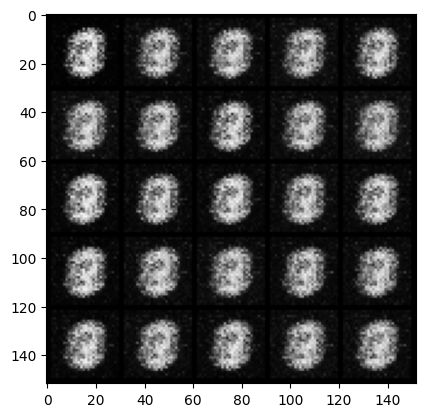

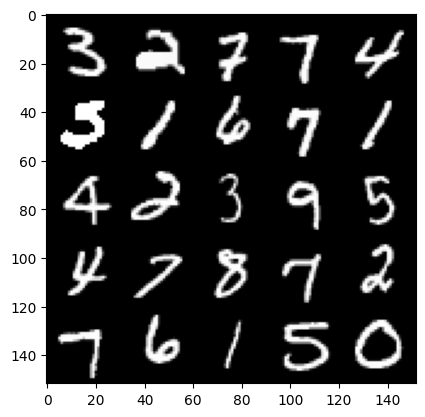

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.7448537800312052, discriminator loss: 0.28215272763371474


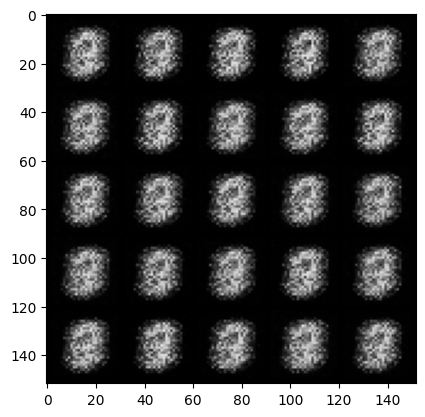

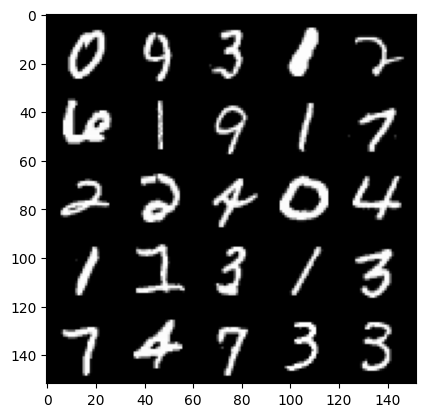

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 2.07339559149742, discriminator loss: 0.15758376897871498


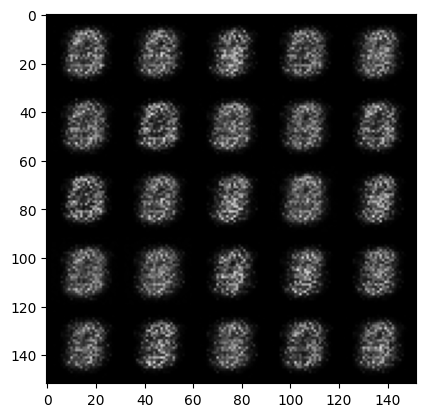

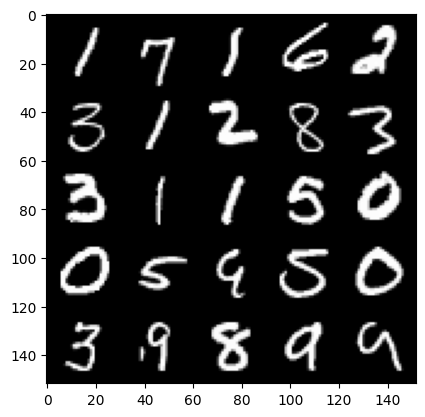

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.765062981605529, discriminator loss: 0.21133856245875382


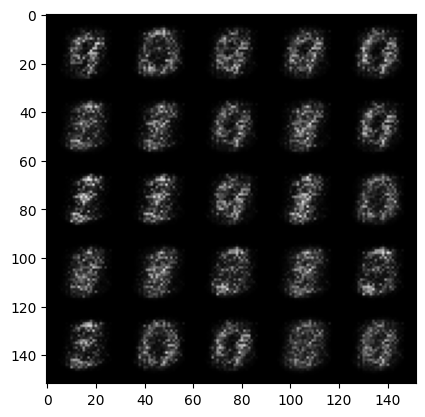

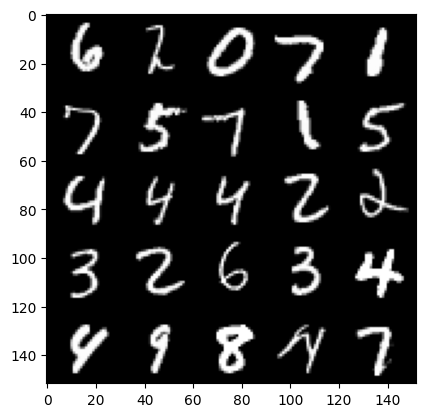

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.7096515264511105, discriminator loss: 0.20562794545292862


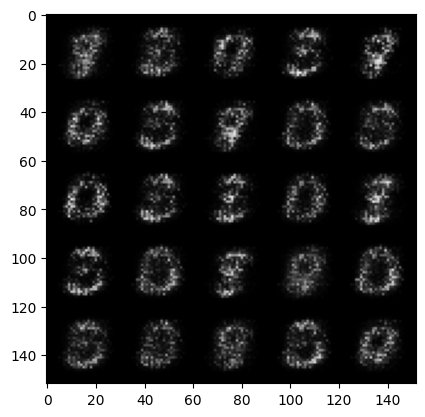

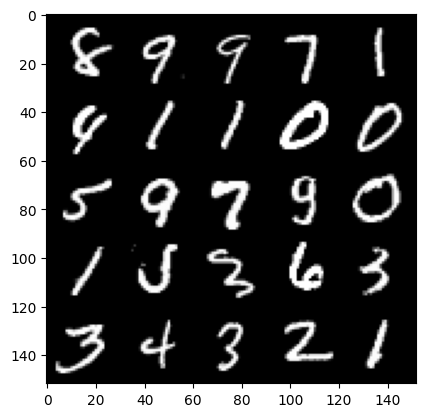

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 1.9804345481395724, discriminator loss: 0.16591502024233354


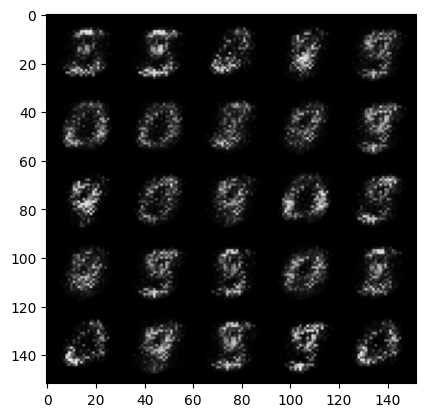

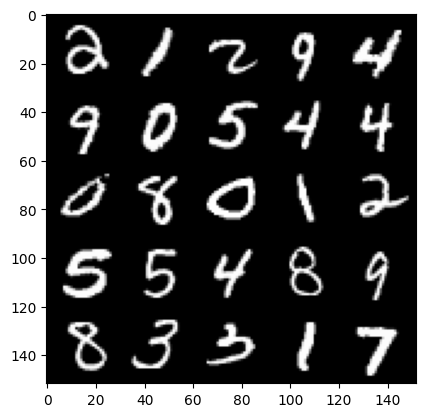

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 2.306661281824115, discriminator loss: 0.15317549799382685


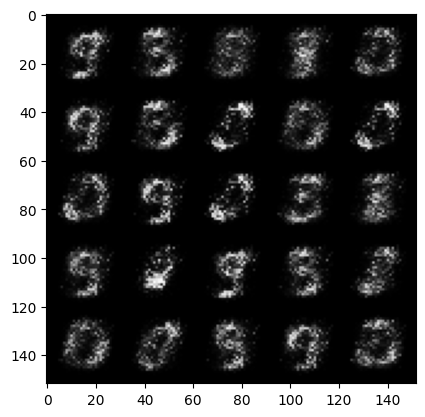

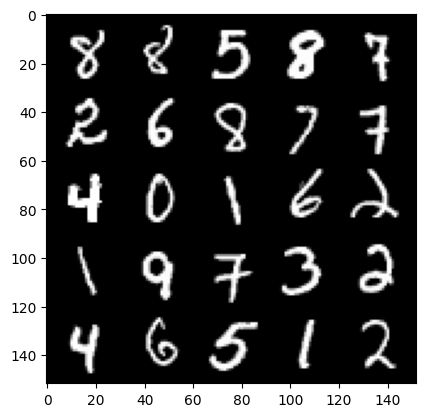

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 2.650205523967743, discriminator loss: 0.12977320675551887


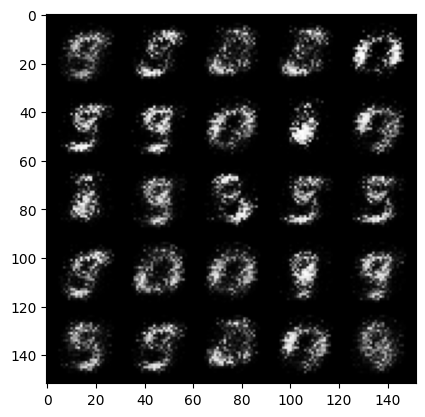

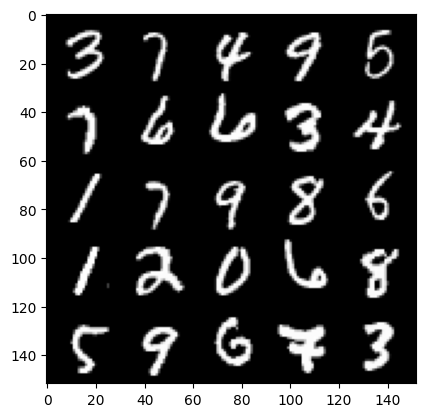

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 3.1035711669921886, discriminator loss: 0.09177666001766926


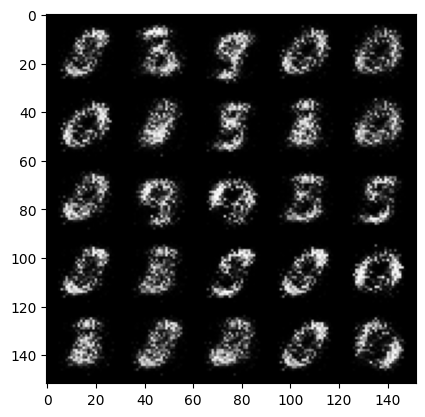

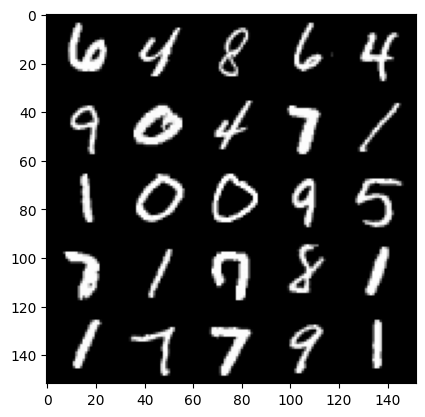

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 3.4385650753974937, discriminator loss: 0.07149465807527304


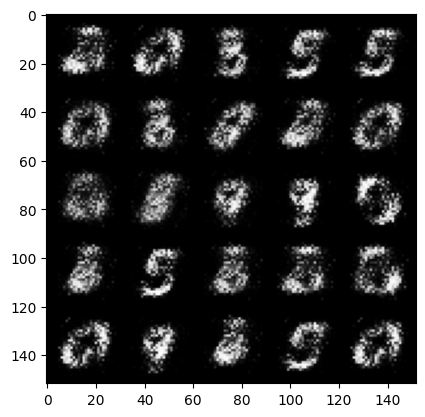

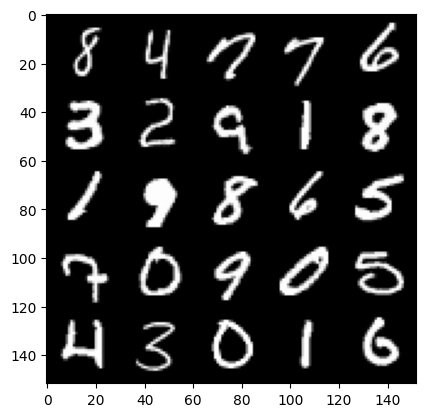

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 3.6012757248878478, discriminator loss: 0.06620396995544431


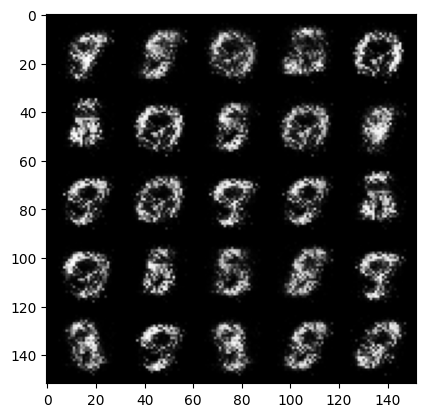

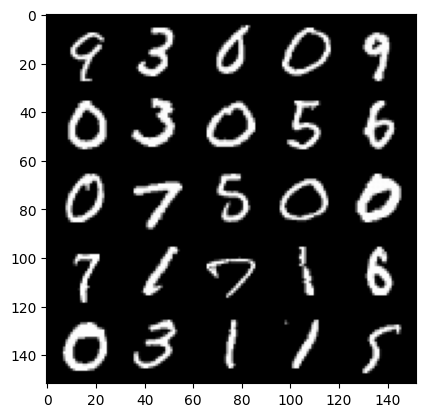

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 3.7693157305717477, discriminator loss: 0.06573400496691471


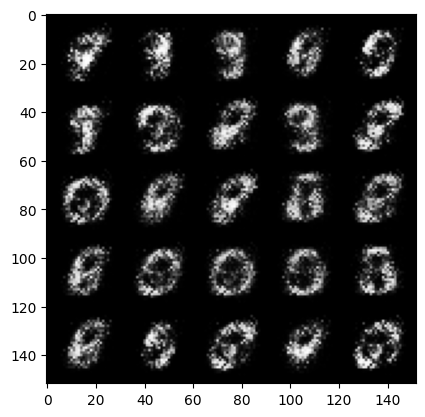

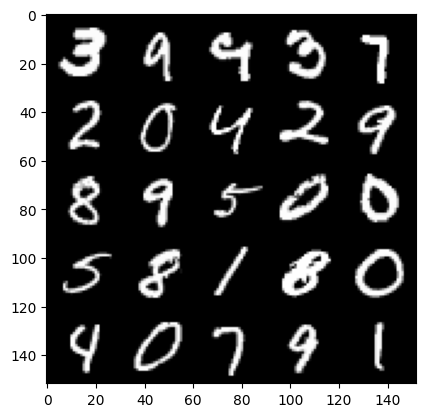

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
# OPTIONAL PART

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        #     Hint: This code will look a lot like the discriminator updates!
        #     These are the steps you will need to complete:
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
        #### START CODE HERE ####
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()
        #### END CODE HERE ####

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


如果你没有遇到任何运行时错误，这意味着你的代码是有效的。我们检查函数中每次迭代的权重是否在变化。

**恭喜你，成功训练了你的第一个GAN**